# Finding the Max Sharpe Ratio Portfolio

In [1]:
%load_ext autoreload
%autoreload 2

import edhec_risk_kit as erk
import pandas as pd
import numpy as np

In [2]:
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

In [10]:
from scipy.optimize import minimize

def msr(riskfree_rate, er, cov):
    """
    RiskFree Rate + ER + COV -> W
    """
    # Number of assets
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    # Constraints
    # Weight bounds: minimum of 0 and maximum of 100%
    bounds = ((0.0, 1.0),)*n
    # Weights sum to 1
    weights_sum_to_1 = {
        "type": "eq",
        "fun": lambda weights: np.sum(weights) - 1
    }
    
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio, given weights
        """
        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    # Maximize sharpe ratio
    results = minimize(neg_sharpe_ratio, init_guess,
                       args=(riskfree_rate, er, cov), method="SLSQP",
                       options={"disp": False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return results.x

Compute the weights of the max sharpe ratio portfolio
* given the risk-free rate and expected returns vector and the covariance matrix.
    
1. Find the number of asseets
2. Make an initial guess that is just equally weighting all of them.
    * Weights have to be greater than 0 and less than 1
    * Weights all sum to one
    * No leverage in other words
3. Get the optimizer to minimize the negative of the Sharpe ratio.
4. Objective function: given a set of weights, the expected return vector and the covariance matrix, and the risk-free rate,
    * compute the return
    * compute the volatility
    * compute the sharpe ratio
    * the negative of this is what we want

## Plot Efficient Frontier

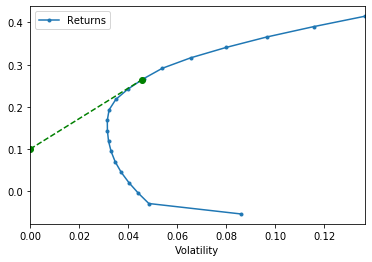

In [11]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left=0)
rf = 0.1
w_msr = msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)

# Add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]

ax.plot(cml_x, cml_y, color="green", marker="o", linestyle="dashed")

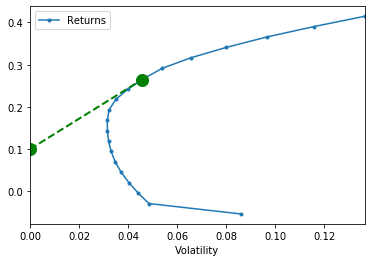

In [14]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1)